In [234]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from causalgraphicalmodels import CausalGraphicalModel, StructuralCausalModel
import pylogit
from collections import OrderedDict
import pylogit as cm
from functools import reduce
import statsmodels.api as sm
import statsmodels.formula.api as smf
from math import ceil

from IPython import display
import seaborn as sns

import tensorflow as tf
import numpy as np
import numpy.random as npr
import pandas as pd
import tensorflow as tf
import tensorflow_probability as tfp
import statsmodels.api as sm

from tensorflow_probability import edward2 as ed
from sklearn.datasets import load_breast_cancer
from pandas.plotting import scatter_matrix
from scipy import sparse, stats
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression 
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve

import matplotlib
matplotlib.rcParams.update({'font.sans-serif' : 'Helvetica',
                            'axes.labelsize': 10,
                            'xtick.labelsize' : 6,
                            'ytick.labelsize' : 6,
                            'axes.titlesize' : 10})
import matplotlib.pyplot as plt

import seaborn as sns
color_names = ["windows blue",
               "amber",
               "crimson",
               "faded green",
               "dusty purple",
               "greyish"]
colors = sns.xkcd_palette(color_names)
sns.set(style="white", palette=sns.xkcd_palette(color_names), color_codes = False)


import os
os.listdir('.')

['Factor_Model_tuning.py',
 '.DS_Store',
 'investigating_deconfounder.ipynb',
 '.gitkeep',
 'Causal_Graph_Tim_Data.ipynb',
 'Factor_Model_tuning.ipynb',
 'spring_2016_all_bay_area_long_format_plus_cross_bay_col.csv',
 '.ipynb_checkpoints']

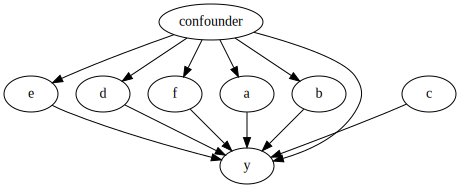

In [146]:
drive_alone_graph = CausalGraphicalModel(
    nodes=['a', 'b', 'c', 'confounder',
          'd',  'e', 'f', 'y'],
    edges=[
        ("a", "y"), 
        ("b", "y"), 
        ("c", "y"), 
        ("d", "y"), 
        ("e", "y"), 
        ("f", "y"), 
        ("confounder", "y"), 
        
        
        ("confounder", "a"),
        ("confounder", "b"),
#         ("confounder", "c"),
        ("confounder", "d"),
        ("confounder", "e"),
        ("confounder", "f"),


        
        
        ("confounder", "y"), 
        ("confounder", "y"), 
    ]
)

# draw return a graphviz `dot` object, which jupyter can render
drive_alone_graph.draw()

In [83]:
sample_size = 10000

confounder = np.random.normal(loc=20, scale = 5, size = sample_size)

In [207]:
a = .3*confounder + np.random.normal(loc=10,scale=3,size=sample_size)
b = -1*confounder + np.random.normal(loc=6,scale=3,size=sample_size)
c = np.random.normal(loc=15,scale=3,size=sample_size) # + .5*confounder 
d = .8*confounder + np.random.normal(loc=-10,scale=3,size=sample_size)
e = .5*confounder + np.random.normal(loc=8,scale=3,size=sample_size)
f= -.3*confounder + np.random.normal(loc=-12,scale=3,size=sample_size)
y = 5 + 2*a + 2*b - 5*c + 3*d + 2*e - 5*f + 7*confounder + np.random.normal(loc=0,scale=1,size=sample_size)

coeffs_true = [5,2,2,-5,3,2,-5,7]

# plt.hist(confounder, bins = 50)

# plt.hist(f, bins = 50)

In [208]:
df = pd.DataFrame(np.array([a,b,c,d,e,f,confounder, y]).T, columns = ['a', 'b', 'c',
          'd',  'e', 'f', 'confounder', 'y'])
df.head()

,a,b,c,d,e,f,confounder,y
0,17.129317,-13.409884,19.939753,17.445532,21.152334,-15.036494,23.202018,244.577624
1,13.873707,-11.488999,17.219449,4.620337,18.935854,-18.707793,18.029553,192.753420
2,20.917771,-16.239104,9.966072,3.060020,21.423327,-16.447743,24.445583,271.386207
3,11.950380,0.315945,18.295736,-3.685726,10.905031,-16.718011,7.865004,86.581291
4,17.646020,-29.679195,13.505814,13.149911,24.661485,-17.808366,29.915356,299.587314


In [209]:
# sns.pairplot(df, size=1.5)

In [210]:
ols_formula = "y ~ a+b+c+d+e+f"#+confounder "

model_full = smf.ols(ols_formula, data=df)
results_full = model_full.fit()
results_df = pd.DataFrame(results_full.params, columns = ['estimated_params'])
results_df['std_errors'] = results_full.bse
results_df['true_params'] = coeffs_true[:-1]
results_df

,estimated_params,std_errors,true_params
Intercept,35.833276,1.244090,5
a,2.869080,0.044344,2
b,-0.881779,0.034656,2
c,-5.022889,0.045164,-5
d,5.301479,0.038287,3
e,3.421101,0.042999,2
f,-5.885477,0.043566,-5


In [211]:
model_partial = smf.ols("y ~ a+b+c+d+e+f ", data=df)
results_partial = model_partial.fit()
results_df_partial = pd.DataFrame(results_partial.params, columns = ['estimated_params'])
results_df_partial['std_errors'] = results_partial.bse
results_df_partial['true_params'] = coeffs_true[:-1]
results_df_partial

,estimated_params,std_errors,true_params
Intercept,35.833276,1.244090,5
a,2.869080,0.044344,2
b,-0.881779,0.034656,2
c,-5.022889,0.045164,-5
d,5.301479,0.038287,3
e,3.421101,0.042999,2
f,-5.885477,0.043566,-5


## Factor analysis: Is there evidence of latent factors?

In [135]:
from factor_analyzer.factor_analyzer import calculate_bartlett_sphericity,calculate_kmo

In [283]:
chi_square_value,p_value=calculate_bartlett_sphericity(df[['a','b','c','d','e','f']])
print("Bartlett sphericity test indicates potential latent confounder, with a p-value of: ", p_value)

Bartlett sphericity test indicates potential latent confounder, with a p-value of:  0.0


In [284]:
# kmo_all,kmo_model=calculate_kmo(df[['a','b','c','d','e','f']])
# kmo_model

## Fit PCA



In [285]:
X_columns = [
    'a',
       'b', 
    'c',
    'd',
    'e',
    'f'
            ]


X = np.array((df[X_columns] - df[X_columns].mean())/df[X_columns].std())


### Using sklearn

In [286]:
from sklearn.decomposition import PCA

In [287]:
pca = PCA(n_components=1)
principalComponents = pca.fit_transform(X)

### Using the cross-validation: see function specified below

In [288]:
U, Vt, train_err, test_err, M, resid = cv_pca(data=X, rank=1)
train_err, test_err


(0.514037095372499, 1.2128243080982832)

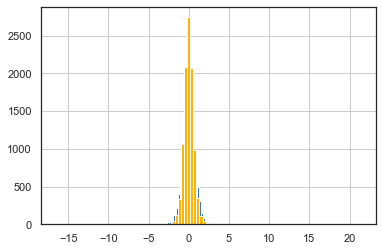

In [289]:
fig, ax = plt.subplots()
display.display(pd.Series(resid[:,0]).hist(bins=100))

# fig, ax = plt.subplots()
display.display(pd.Series(resid[:,1]).hist(bins=100))

### Using PPCA from Blei et. al's tutorial

Inferred axes:
[[ 0.61158603 -0.8786599   0.02002429  0.8590854   0.78314894 -0.60986716]]
Standard Deviation:
[[0.00636657 0.00616885 0.00501387 0.00585176 0.0060134  0.00628234]]


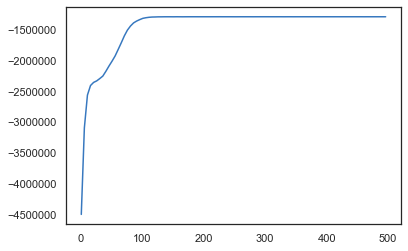

1

P-value, average:  [0.39613950177935947]


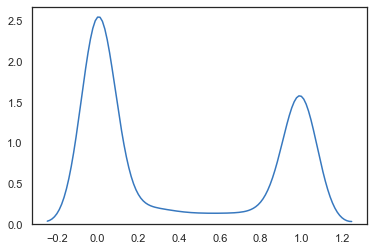

In [290]:
latent_dim = 1

confounders, holdouts, holdoutmasks, holdoutrow= confounder(holdout_portion=0.2, X=X, latent_dim=latent_dim)

holdouts_req = [holdouts]
display.display(len(holdouts_req))

confounder_req = [confounders]

n_rep = 100 # number of replicated datasets we generate
holdout_gen_util = []

for j in range(len(holdouts_req)):
    holdout_gen = np.zeros((n_rep,*(holdouts_req[j].shape)))
    
    for i in range(n_rep):
        w_sample = npr.normal(confounder_req[j][0], confounder_req[j][1])
        z_sample = npr.normal(confounder_req[j][2], confounder_req[j][3])
        
        data_dim_temp = holdouts_req[j].shape[1]
        latent_dim_temp = confounder_req[j][2].shape[1]
        num_datapoints_temp = holdouts_req[j].shape[0]
        
        with ed.interception(replace_latents(w_sample, z_sample)):
            generate = ppca_model(
                data_dim=data_dim_temp, latent_dim=latent_dim_temp,
                num_datapoints=num_datapoints_temp, stddv_datapoints=0.1, holdout_mask=holdoutmasks)

        with tf.Session() as sess:
            x_generated, _ = sess.run(generate)

        # look only at the heldout entries
        holdout_gen[i] = np.multiply(x_generated, holdoutmasks)
        
    holdout_gen_util.append(holdout_gen)
    
    
n_eval = 100 # we draw samples from the inferred Z and W
obs_ll_per_zi_per_mode = []
rep_ll_per_zi_per_mode = []
stddv_datapoints=0.1
for mode in range(len(holdouts_req)):
    obs_ll = []
    rep_ll = []

    for j in range(n_eval):
        w_sample = npr.normal(confounder_req[mode][0], confounder_req[mode][1])
        z_sample = npr.normal(confounder_req[mode][2], confounder_req[mode][3])

        holdoutmean_sample = np.multiply(z_sample.dot(w_sample), holdoutmasks)
        obs_ll.append(np.mean(stats.norm(holdoutmean_sample, \
                            stddv_datapoints).logpdf(holdouts_req[mode]), axis=1))

        rep_ll.append(np.mean(stats.norm(holdoutmean_sample, \
                            stddv_datapoints).logpdf(holdout_gen_util[mode]),axis=2))

    obs_ll_per_zi, rep_ll_per_zi = np.mean(np.array(obs_ll), axis=0), np.mean(np.array(rep_ll), axis=0)
    obs_ll_per_zi_per_mode.append(obs_ll_per_zi)
    rep_ll_per_zi_per_mode.append(rep_ll_per_zi)

    
pval_mode = []
for mode in range(len(holdouts_req)):
    pvals = np.array([np.mean(rep_ll_per_zi_per_mode[mode][:,i] < obs_ll_per_zi_per_mode[mode][i]) 
                      for i in range(holdouts_req[mode].shape[0])])
    holdout_subjects = np.unique(holdoutrow)
    overall_pval = np.mean(pvals[holdout_subjects])
    pval_mode.append(overall_pval)
#     print("Predictive check p-values", overall_pval)

print("P-value, average: ", pval_mode)

display.display(sns.kdeplot(pvals[holdout_subjects]))

## Re-estimating regression with and without confounder

Notice I designed the simulation such that ommitting the confounder will flip the sign of the coefficient on $b$. When we add the confounder, estimated using any PCA variation, the coefficient on $b$ remains flipped. 

In [291]:
df['confounder_PCA_SKLEARN'] = principalComponents[:,0]

df['confounder_PCA_CV'] = U[:,0]

df['confounder_PPCA'] = confounders[2]

In [292]:
model_deconf = smf.ols("y ~ a+b+c+d+e+f ", data=df)
results_deconf = model_deconf.fit()
results_df_deconf = pd.DataFrame(results_deconf.params, columns = ['estimated_params'])
results_df_deconf['std_errors'] = results_deconf.bse
results_df_deconf['true_params'] = coeffs_true[:-1]
results_df_deconf

,estimated_params,std_errors,true_params
Intercept,35.833276,1.244090,5
a,2.869080,0.044344,2
b,-0.881779,0.034656,2
c,-5.022889,0.045164,-5
d,5.301479,0.038287,3
e,3.421101,0.042999,2
f,-5.885477,0.043566,-5


In [293]:
model_deconf = smf.ols("y ~ a+b+c+d+e+f+confounder_PCA_CV ", data=df)
results_deconf = model_deconf.fit()
results_df_deconf = pd.DataFrame(results_deconf.params, columns = ['estimated_params'])
results_df_deconf['std_errors'] = results_deconf.bse
results_df_deconf['true_params'] = coeffs_true
results_df_deconf

,estimated_params,std_errors,true_params
Intercept,35.742885,1.649952,5
a,2.870427,0.047195,2
b,-0.882735,0.036502,2
c,-5.022689,0.045229,-5
d,5.302641,0.040745,3
e,3.422333,0.045469,2
f,-5.886757,0.046191,-5
confounder_PCA_CV,0.000741,0.008881,7


In [294]:
model_deconf = smf.ols("y ~ a+b+c+d+e+f+confounder_PCA_SKLEARN ", data=df)
results_deconf = model_deconf.fit()
results_df_deconf = pd.DataFrame(results_deconf.params, columns = ['estimated_params'])
results_df_deconf['std_errors'] = results_deconf.bse
results_df_deconf['true_params'] = coeffs_true
results_df_deconf

,estimated_params,std_errors,true_params
Intercept,0.867239,0.021083,5
a,3.351995,0.040339,2
b,-1.292711,0.038907,2
c,-4.987185,0.044502,-5
d,5.763495,0.045158,3
e,3.956896,0.039740,2
f,-6.354348,0.038490,-5
confounder_PCA_SKLEARN,-4.537594,0.158712,7


In [296]:
model_deconf = smf.ols("y ~ a+b+c+d+e+f+confounder_PPCA ", data=df)
results_deconf = model_deconf.fit()
results_df_deconf = pd.DataFrame(results_deconf.params, columns = ['estimated_params'])
results_df_deconf['std_errors'] = results_deconf.bse
results_df_deconf['true_params'] = coeffs_true
results_df_deconf

,estimated_params,std_errors,true_params
Intercept,32.173869,2.948525,5
a,2.921938,0.058797,2
b,-0.922260,0.045557,2
c,-5.022827,0.045162,-5
d,5.348542,0.051456,3
e,3.478109,0.059859,2
f,-5.936936,0.057541,-5
confounder_PPCA,-0.804642,0.587799,7


## Functions and fun stuff

In [79]:
def create_confounded_df(x, y, slope, groups):
    b = 0
    d = distance_line(b, slope, x, y)
    
    d_scaled = 0.0001 + .9999*(d-min(d))/(max(d)-min(d))
    
    df = pd.DataFrame()
    
    df['x'] = x
    df['y'] = y
    
    
    
    df['group'] = pd.Categorical(np.array([ceil(groups*(i)) for i in d_scaled]))
    
    return df
    
#     df['group'] = df['group'].astype('category')
     
    
def distance_line(b, m, x, y):
    return (y - (m*x + b))/np.sqrt(m**2 + 1)

test_df = create_confounded_df(x=a,y=y,slope=1, groups=100)

model = smf.ols("y ~ a + group", data=test_df)
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.999
Model:                            OLS   Adj. R-squared:                  0.999
Method:                 Least Squares   F-statistic:                 2.133e+05
Date:                Wed, 25 Mar 2020   Prob (F-statistic):               0.00
Time:                        13:32:37   Log-Likelihood:                -6089.2
No. Observations:               10000   AIC:                         1.235e+04
Df Residuals:                    9913   BIC:                         1.298e+04
Df Model:                          86                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept      -27.6719      0.447    -61.908      0.000     -28.548     -26.796
group[T.3]       4.4686      0.632      7.071      0.000       3.230       5.707
group[T.4]       4.7619      0.632      7.535      0.000       3.523       6.001
group[T.5]       7.6038      0.632     12.031      0.000       6.365       8.843
group[T.6]       8.4020      0.516     16.284      0.000       7.391       9.413
group[T.7]      10.3645      0.516     20.085      0.000       9.353      11.376
group[T.9]      13.0245      0.547     23.801      0.000      11.952      14.097
group[T.10]     15.5903      0.632     24.669      0.000      14.352      16.829
group[T.11]     16.7499      0.483     34.704      0.000      15.804      17.696
group[T.12]     17.9781      0.483     37.245      0.000      17.032      18.924
group[T.13]     19.3180      0.483     40.023      0.000      18.372      20.264
group[T.14]     21.1401      0.483     43.799      0.000      20.194      22.086
group[T.15]     22.5349      0.471     47.837      0.000      21.612      23.458
group[T.16]     24.2629      0.469     51.772      0.000      23.344      25.182
group[T.17]     25.7891      0.455     56.627      0.000      24.896      26.682
group[T.18]     27.3841      0.457     59.932      0.000      26.488      28.280
group[T.19]     28.9791      0.455     63.721      0.000      28.088      29.871
group[T.20]     30.4455      0.452     67.313      0.000      29.559      31.332
group[T.21]     32.0883      0.452     70.923      0.000      31.201      32.975
group[T.22]     33.6368      0.451     74.517      0.000      32.752      34.522
group[T.23]     35.1853      0.452     77.909      0.000      34.300      36.071
group[T.24]     36.7890      0.450     81.690      0.000      35.906      37.672
group[T.25]     38.3739      0.450     85.317      0.000      37.492      39.256
group[T.26]     39.9499      0.450     88.870      0.000      39.069      40.831
group[T.27]     41.5782      0.449     92.559      0.000      40.698      42.459
group[T.28]     43.0638      0.449     95.975      0.000      42.184      43.943
group[T.29]     44.6491      0.449     99.534      0.000      43.770      45.528
group[T.30]     46.1799      0.448    102.995      0.000      45.301      47.059
group[T.31]     47.7825      0.448    106.571      0.000      46.904      48.661
group[T.32]     49.3485      0.448    110.097      0.000      48.470      50.227
group[T.33]     50.8972      0.448    113.628      0.000      50.019      51.775
group[T.34]     52.4535      0.448    117.088      0.000      51.575      53.332
group[T.35]     53.9608      0.448    120.482      0.000      53.083      54.839
group[T.36]     55.5945      0.448    124.149      0.000      54.717      56.472
group[T.37]     57.1614      0.448    127.646      0.000      56.284      58.039
group

In [117]:
import numpy as np
from numpy.random import randn, rand
from scipy.optimize import minimize
import matplotlib.pyplot as plt
# from nnls import nnlsm_blockpivot as nnlstsq
import itertools
from scipy.spatial.distance import cdist

def censored_lstsq(A, B, M):
    """Solves least squares problem with missing data in B
    Note: uses a broadcasted solve for speed.
    Args
    ----
    A (ndarray) : m x r matrix
    B (ndarray) : m x n matrix
    M (ndarray) : m x n binary matrix (zeros indicate missing values)
    Returns
    -------
    X (ndarray) : r x n matrix that minimizes norm(M*(AX - B))
    """

    if A.ndim == 1:
        A = A[:,None]

    # else solve via tensor representation
    rhs = np.dot(A.T, M * B).T[:,:,None] # n x r x 1 tensor
    T = np.matmul(A.T[None,:,:], M.T[:,:,None] * A[None,:,:]) # n x r x r tensor
    try:
        # transpose to get r x n
        return np.squeeze(np.linalg.solve(T, rhs), axis=-1).T
    except:
        r = T.shape[1]
        T[:,np.arange(r),np.arange(r)] += 1e-6
        return np.squeeze(np.linalg.solve(T, rhs), axis=-1).T



def cv_pca(data, rank, M=None, p_holdout=0.3, nonneg=False, iterations = 1000):
    """Fit PCA while holding out a fraction of the dataset.
    """

#     # choose solver for alternating minimization
#     if nonneg:
#         solver = censored_nnlstsq
#     else:
    solver = censored_lstsq

    # create masking matrix
    if M is None:
        M = np.random.rand(*data.shape) > p_holdout

    # initialize U randomly
    if nonneg:
        U = np.random.rand(data.shape[0], rank)
    else:
        U = np.random.randn(data.shape[0], rank)

    # fit pca/nmf
    for itr in range(iterations):
        Vt = solver(U, data, M)
        U = solver(Vt.T, data.T, M.T).T

    # return result and test/train error
    resid = np.dot(U, Vt) - data
    train_err = np.mean(resid[M]**2)
    test_err = np.mean(resid[~M]**2)
    return U, Vt, train_err, test_err, M, resid

In [233]:
def confounder(X, latent_dim, holdout_portion):
    # randomly holdout some entries of X
    num_datapoints, data_dim = X.shape

    holdout_portion = holdout_portion
    n_holdout = int(holdout_portion * num_datapoints * data_dim)

    holdout_row = np.random.randint(num_datapoints, size=n_holdout)
    holdout_col = np.random.randint(data_dim, size=n_holdout)
    holdout_mask = (sparse.coo_matrix((np.ones(n_holdout), \
                                (holdout_row, holdout_col)), \
                                shape = X.shape)).toarray()

    holdout_subjects = np.unique(holdout_row)

    x_train = np.multiply(1-holdout_mask, X)
    x_vad = np.multiply(holdout_mask, X)

    def ppca_model(data_dim, latent_dim, num_datapoints, stddv_datapoints):
        w = ed.Normal(loc=tf.zeros([latent_dim, data_dim]),
                    scale=tf.ones([latent_dim, data_dim]),
                    name="w")  # parameter
        z = ed.Normal(loc=tf.zeros([num_datapoints, latent_dim]),
                    scale=tf.ones([num_datapoints, latent_dim]), 
                    name="z")  # local latent variable / substitute confounder
        x = ed.Normal(loc=tf.multiply(tf.matmul(z, w), 1-holdout_mask),
                    scale=stddv_datapoints * tf.ones([num_datapoints, data_dim]),
                    name="x")  # (modeled) data
        return x, (w, z)

    log_joint = ed.make_log_joint_fn(ppca_model)

    latent_dim = latent_dim
    stddv_datapoints = 0.1

    model = ppca_model(data_dim=data_dim,
                       latent_dim=latent_dim,
                       num_datapoints=num_datapoints,
                       stddv_datapoints=stddv_datapoints)

    def variational_model(qw_mean, qw_stddv, qz_mean, qz_stddv):
        qw = ed.Normal(loc=qw_mean, scale=qw_stddv, name="qw")
        qz = ed.Normal(loc=qz_mean, scale=qz_stddv, name="qz")
        return qw, qz


    log_q = ed.make_log_joint_fn(variational_model)

    def target(w, z):
        """Unnormalized target density as a function of the parameters."""
        return log_joint(data_dim=data_dim,
                       latent_dim=latent_dim,
                       num_datapoints=num_datapoints,
                       stddv_datapoints=stddv_datapoints,
                       w=w, z=z, x=x_train)

    def target_q(qw, qz):
        return log_q(qw_mean=qw_mean, qw_stddv=qw_stddv,
                   qz_mean=qz_mean, qz_stddv=qz_stddv,
                   qw=qw, qz=qz)


    qw_mean = tf.Variable(np.ones([latent_dim, data_dim]), dtype=tf.float32)
    qz_mean = tf.Variable(np.ones([num_datapoints, latent_dim]), dtype=tf.float32)
    qw_stddv = tf.nn.softplus(tf.Variable(-4 * np.ones([latent_dim, data_dim]), dtype=tf.float32))
    qz_stddv = tf.nn.softplus(tf.Variable(-4 * np.ones([num_datapoints, latent_dim]), dtype=tf.float32))

    qw, qz = variational_model(qw_mean=qw_mean, qw_stddv=qw_stddv,
                               qz_mean=qz_mean, qz_stddv=qz_stddv)


    energy = target(qw, qz)
    entropy = -target_q(qw, qz)

    elbo = energy + entropy


    optimizer = tf.train.AdamOptimizer(learning_rate = 0.05)
    train = optimizer.minimize(-elbo)

    init = tf.global_variables_initializer()

    t = []

    num_epochs = 500

    with tf.Session() as sess:
        sess.run(init)

        for i in range(num_epochs):
            sess.run(train)
            if i % 5 == 0:
                t.append(sess.run([elbo]))

            w_mean_inferred = sess.run(qw_mean)
            w_stddv_inferred = sess.run(qw_stddv)
            z_mean_inferred = sess.run(qz_mean)
            z_stddv_inferred = sess.run(qz_stddv)

    print("Inferred axes:")
    print(w_mean_inferred)
    print("Standard Deviation:")
    print(w_stddv_inferred)

    plt.plot(range(1, num_epochs, 5), t)
    plt.show()

    def replace_latents(w, z):

        def interceptor(rv_constructor, *rv_args, **rv_kwargs):
            """Replaces the priors with actual values to generate samples from."""
            name = rv_kwargs.pop("name")
            if name == "w":
                rv_kwargs["value"] = w
            elif name == "z":
                rv_kwargs["value"] = z
            return rv_constructor(*rv_args, **rv_kwargs)

        return interceptor
    
    return [w_mean_inferred, w_stddv_inferred, z_mean_inferred, z_stddv_inferred], x_vad, holdout_mask, holdout_row

In [257]:
def ppca_model(data_dim, latent_dim, num_datapoints, stddv_datapoints, holdout_mask):
    w = ed.Normal(loc=tf.zeros([latent_dim, data_dim]),
                scale=tf.ones([latent_dim, data_dim]),
                name="w")  # parameter
    z = ed.Normal(loc=tf.zeros([num_datapoints, latent_dim]),
                scale=tf.ones([num_datapoints, latent_dim]), 
                name="z")  # local latent variable / substitute confounder
    x = ed.Normal(loc=tf.multiply(tf.matmul(z, w), 1-holdout_mask),
                scale=stddv_datapoints * tf.ones([num_datapoints, data_dim]),
                name="x")  # (modeled) data
    return x, (w, z)



def variational_model(qw_mean, qw_stddv, qz_mean, qz_stddv):
    qw = ed.Normal(loc=qw_mean, scale=qw_stddv, name="qw")
    qz = ed.Normal(loc=qz_mean, scale=qz_stddv, name="qz")
    return qw, qz



def target(w, z):
    """Unnormalized target density as a function of the parameters."""
    return log_joint(data_dim=data_dim,
                   latent_dim=latent_dim,
                   num_datapoints=num_datapoints,
                   stddv_datapoints=stddv_datapoints,
                   w=w, z=z, x=x_train)

def target_q(qw, qz):
    return log_q(qw_mean=qw_mean, qw_stddv=qw_stddv,
               qz_mean=qz_mean, qz_stddv=qz_stddv,
               qw=qw, qz=qz)

def replace_latents(w, z):

    def interceptor(rv_constructor, *rv_args, **rv_kwargs):
        """Replaces the priors with actual values to generate samples from."""
        name = rv_kwargs.pop("name")
        if name == "w":
            rv_kwargs["value"] = w
        elif name == "z":
            rv_kwargs["value"] = z
        return rv_constructor(*rv_args, **rv_kwargs)

    return interceptor